In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [40]:
regions = (
    pd.read_csv('data/census_regions.csv',
                header=0, names=['state', 'stateabbrv', 'region', 'div'])
    .drop(columns=['div'])
)

outlier_czs = [34105, 34113, 34112, 34106]
df = (
    pd.read_csv('data/mobility.csv')
    # filter out rows with NaN AUM values
    .query('not aum.isnull()', engine='python')
    # take out outlier CZs
    .query('cz not in @outlier_czs')
    .merge(regions, on='stateabbrv')
#     [['czname', 'region', 'stateabbrv', 'aum']]
    [['region', 'aum']]
)

(sec:linear_feature_eng)=
# Feature Engineering

So far, our model requires all of the predictor variables to be numeric.
But categorical data is often useful for prediction as well.
For example, the map below colors each state by its AUM.
We can see that AUM varies between regions in the US---the southeast region
of the US has much lower AUMs than the midwestern region.
This suggests that including the region into our linear model can help 
with prediction.

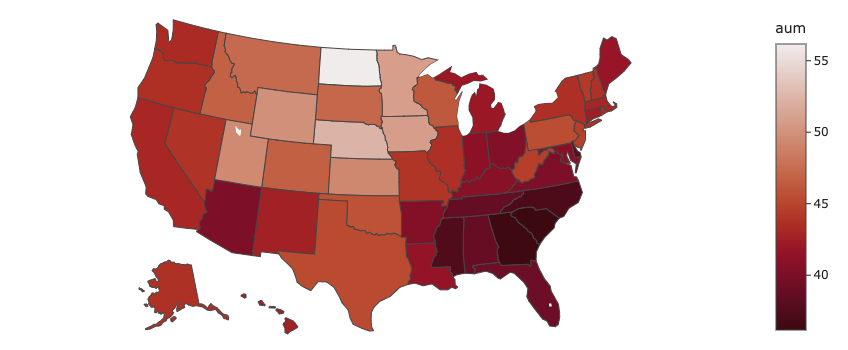

In [25]:
states = df.groupby('stateabbrv')['aum'].mean().reset_index()
px.choropleth(states,
              locations='stateabbrv', 
              locationmode="USA-states", 
              scope="usa",
              color='aum',
              color_continuous_scale="amp_r", 
              width=550, height=350,
             )

Since our model needs the design matrix $ X $ to only contain numeric values,
we'll use a *feature engineering* technique to enable our model to make use
of the categorical US region feature.
Feature engineering is the process of transforming data before model fitting 
so that the model can capture more kinds of patterns.
In this case, we'll use a technique called *one-hot encoding* to
transform categorical data into numeric data.

## One-Hot Encoding

A one-hot encoding takes a categorical feature and creates multiple numeric
features.
To do a one-hot encoding, we first create new features that each correspond to
one unique category.
In this case, we have four US Census regions:
West, Northeast, South, and Midwest.
Since we have four categories, we'll create four new features in the design
matrix $ X $.
Each row in $ X $ contains the value `1` if the feature matches the
original category and `0` otherwise.
We've illustrated this process in {numref}`Figure %s <fig:one-hot>`.

```{figure} figures/one-hot.svg
---
name: fig:one-hot
width: 100%
---

One-hot encoding for a small example dataset (left) and its resulting design matrix (right).
```

After doing this transformation, we usually remove one of the new
feature columns from the design matrix.
If we don't do this, then the columns of the design matrix will be linearly
dependent after we add the intercept column, which means that we won't have
a useful interpretation for the model coefficients---we've left
this proof as an exercise.
We'll talk about what removing a column means later in this section.
For now, we'll simply remove the first one-hot encoded column.

Let's use a one-hot encoding on the Opportunity data.
We'll start with a subset of the data which just has the commuting zone's
AUM and its US Census region:

In [41]:
df

,region,aum
0,South,38.39
1,South,37.78
2,South,39.05
...,...,...
702,West,44.12
703,West,41.41
704,West,43.20


To do the encoding, we'll use the `scikit-learn` library's
`OneHotEncoder` class.

In [52]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(
    # categories argument sets column order
    categories=[['Northeast', 'West', 'Midwest', 'South']],
    drop='first',
    sparse=False,
)
X = enc.fit_transform(df[['region']])
X

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Now, we have a design matrix stored in the variable `X`. 
Since we've dropped the `Northeast` column from the design matrix,
the three resulting features represent the
`West`, `Midwest`, and `South` regions.
Let's fit a multiple linear model that predicts AUM from the one-hot encoded
regions.
Rather than defining our own functions, we'll use the `LinearRegression` class
from `scikit-learn`.

In [60]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, df['aum'])

:::{note}

Although we've defined our own model fitting functions earlier in this chapter,
in practice we prefer to use a library like `scikit-learn` for modeling
since its code is highly optimized.
For example, the matrix multiplication code we wrote for fitting
multiple linear models runs very slowly when we have many observations.
`scikit-learn` can handle larger datasets without issue.

:::

## Interpreting Models When Using One-Hot Encoding

Using one-hot encoding gives a natural interpretation for the model parameters.
The intercept of the model represents the expected outcome for the category
we removed from the design matrix.
In our case, we took out the `Northeast` column, so the model's intercept 
parameter represents the predicted AUM for the Northeast region.

In [62]:
print(f'Predicted AUM for Northeast: {model.intercept_:.2f}')

Predicted AUM for Northeast: 44.01


Next, let's look at the model parameters.
We've displayed them in the table below.

In [65]:
pd.DataFrame({'coef': model.coef_}, index=['West', 'Midwest', 'South'])

,coef
West,1.17
Midwest,3.20
South,-3.25


Under a one-hot encoding, each model parameter represents
the model's expected difference between that
region and the Northeast.
For instance, the West has a coefficient of 1.17, which means that the model
predicts that commuting zones in the West will have 1.17 higher AUM than
the Northeast on average.
Likewise, the model predicts that the South has 3.25 lower AUM than the
Northeast.
In other words, the coefficients tell us how the model adjusts the
AUM relative to the Northeast.

We used a small example here to more clearly show how one-hot encoding works.
In practice, we combine the one-hot encoded features with other features
so that our design matrix represents both numeric and categorical features. 

:::{note}

One-hot encoding is also known as using *dummy variables*.
The term dummy variables is more common in statistics and econometrics.

:::

In this section, we introduced feature engineering, where we 
transform data before fitting a model.
We saw how using the one-hot encoding technique lets us fit linear models
on categorical data.
And, one-hot encoding gives us a natural interpretation for model parameters.
There are many other kinds of feature engineering, like using polynomial
terms.
In general, data scientists apply their domain knowledge to figure out
useful feature engineering steps for their models.